In [1]:
import re
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

from actual import actual_effect
from IWLS import IWLS, adaptive_IWLS
from first_order import first_order
from margin import margin

from target import target_value
from utility import data_generation

In [2]:
n = 50
d = 2
k = 5
seeds = [1, 21, 41, 61, 81, 2, 22, 42, 62, 82, 3, 23, 43, 63, 83, 4, 24, 44, 64, 84]
covs = [0.5, 1.0, 2.0, 5.0]

targets = ["probability", "abs_probability", "test_loss", "abs_test_loss", "avg_train_loss", "avg_abs_test_loss", "abs_avg_test_loss"]
target = targets[6]

methods = ["IWLS", "Adaptive IWLS", "Margin-based", "First-order"]
num_methods, num_covs, num_seeds = len(methods), len(covs), len(seeds)

In [3]:
def read_actual_ranks(file_content):
    general_ranks = re.findall(r'Actual rank: (\d+)', file_content)
    result = {
        "IWLS": int(general_ranks[0]),
        "Adaptive IWLS": int(general_ranks[1]),
        "Margin-based": min(int(general_ranks[2]), int(general_ranks[3])),
        "First-order": int(general_ranks[4])
    }
    return result

def read_best_k_subset(file_path):
    # Initialize an empty list to store the best k subset
    best_k_subset = []

    # Open the file and read line by line
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Use regular expressions to find and extract the best k subset
    pattern = re.compile(r'size 5: \[([\d\s]+)\]')
    for line in lines:
        match = pattern.search(line)
        if match:
            # Extract numbers from the matched group and convert to a list of integers
            numbers_str = match.group(1)
            best_k_subset = list(map(int, numbers_str.split()))

            # Break the loop once the information is found
            break

    return best_k_subset

# ratios w.r.t. ground-truth
def score_ratio_per_seed_cov(seed, cov):
    X_train, y_train, X_test, y_test = data_generation(n, d, cov, seed, target=target)
    
    original_value = target_value(X_train, y_train, X_test, y_test, target=target)
    
    ind_n, ind_p = margin(X_train, y_train)

    scores = {
        "Brute Force": actual_effect(X_train, y_train, X_test, y_test, read_best_k_subset(f"results/target={target}/n={n}_d={d}_k={k}/s={seed}_cov={cov}.txt"), original_value, target=target),
        "IWLS": actual_effect(X_train, y_train, X_test, y_test, IWLS(X_train, y_train, X_test, y_test, target=target)[:k], original_value, target=target),
        "Adaptive IWLS": actual_effect(X_train, y_train, X_test, y_test, adaptive_IWLS(X_train, y_train, X_test, y_test, k=k, target=target), original_value, target=target),
        "Margin-based": max(actual_effect(X_train, y_train, X_test, y_test, ind_n[:k], original_value, target=target), actual_effect(X_train, y_train, X_test, y_test, ind_p[:k], original_value, target=target)),
        "First-order": actual_effect(X_train, y_train, X_test, y_test, first_order(X_train, y_train, X_test, y_test, target=target)[:k], original_value, target=target)
    }

    if scores["Brute Force"] == 0:
        return {
            "IWLS": 1 if scores["IWLS"] == 0 else 0,
            "Adaptive IWLS": 1 if scores["Adaptive IWLS"] == 0 else 0,
            "Margin-based": 1 if scores["Margin-based"] == 0 else 0,
            "First-order": 1 if scores["First-order"] == 0 else 0
        }
    
    ratio = {
        "IWLS": scores["IWLS"] / scores["Brute Force"],
        "Adaptive IWLS": scores["Adaptive IWLS"] / scores["Brute Force"],
        "Margin-based": scores["Margin-based"] / scores["Brute Force"],
        "First-order": scores["First-order"] / scores["Brute Force"]
    }
    
    return ratio

In [4]:
rank_array = np.zeros((num_seeds, num_covs, num_methods), dtype=int)

# Process each file and populate the array
for seed_idx, seed in enumerate(seeds):
    for cov_idx, cov in enumerate(covs):
        file_path = f'results/target={target}/n={n}_d={d}_k={k}/s={seed}_cov={cov}.txt'
        with open(file_path, 'r') as file:
            file_content = file.read()
            actual_ranks = read_actual_ranks(file_content)
            # Populate the array
            for method_idx, method_name in enumerate(methods):
                rank_array[seed_idx, cov_idx, method_idx] = actual_ranks.get(method_name, 0)  # Default to 0 if method not found

rank_array = rank_array.swapaxes(0, 2) # method, cov, seed

ratio_array = np.zeros((num_seeds, num_covs, num_methods), dtype=float)
# Process each seed and covariance and populate the array
for seed_idx, seed in enumerate(seeds):
    for cov_idx, cov in enumerate(covs):
        ratio = score_ratio_per_seed_cov(seed, cov)
        for method_idx, method_name in enumerate(methods):
            ratio_array[seed_idx, cov_idx, method_idx] = ratio.get(method_name, 0)  # Default to 0 if method not found

ratio_array = ratio_array.swapaxes(0, 2) # method, cov, seed

In [5]:
# ranks.shape = (num_methods, num_experiments)
def Borda_count(ranks, weights=[4, 3, 2, 1]):
    num_methods, num_experiments = ranks.shape

    weighted_borda_count = np.zeros((num_methods, num_experiments), dtype=int)

    # Calculate weighted Borda count for each seed and covariance
    for experiment_idx in range(num_experiments):
        # Sort indices based on actual ranks for the current experiment
        # tie-handling. ref: https://stackoverflow.com/questions/39059371/can-numpys-argsort-give-equal-element-the-same-rank
        def rankmin(x):
            u, inv, counts = np.unique(x, return_inverse=True, return_counts=True)
            csum = np.zeros_like(counts)
            csum[1:] = counts[:-1].cumsum()
            return csum[inv]

        sorted_indices = rankmin(ranks[:, experiment_idx])

        # Assign weighted Borda count scores
        for method_idx, rank in enumerate(sorted_indices):
            weighted_borda_count[method_idx, experiment_idx] = weights[rank]
            
    total_weighted_borda_count = weighted_borda_count.sum(axis=1)
    ranked_methods_weighted = np.argsort(total_weighted_borda_count)[::-1]
    
    print(f"\nWeighted Borda Count Rankings (target={target}):")
    for rank, method_idx in enumerate(ranked_methods_weighted):
        method_name = methods[method_idx]
        print(f"{rank + 1}. {method_name}: {total_weighted_borda_count[method_idx]}")

    return total_weighted_borda_count

In [6]:
_ = Borda_count(rank_array.reshape((num_methods, num_covs * num_seeds)))


Weighted Borda Count Rankings (target=abs_avg_test_loss):
1. Adaptive IWLS: 293
2. IWLS: 214
3. First-order: 212
4. Margin-based: 181


In [7]:
# ranks.shape = (num_methods, num_experiments)
def hitting_rate(ranks, rank_range=(1, 1)):
    num_methods, num_experiments = ranks.shape

    hitting_rates = np.zeros(num_methods, dtype=float)

    for method_idx in range(num_methods):
        total_hits = 0
        for experiment_idx in range(num_experiments):
            rank = ranks[method_idx, experiment_idx]

            if rank_range[1] == rank_range[0]:
                total_hits += 1 if rank == rank_range[0] else 0
            else:
                total_hits += 1 if rank in range(rank_range[0], rank_range[1] + 1) else 0

        hitting_rates[method_idx] = total_hits / num_experiments

    ranked_methods_hitting = np.argsort(hitting_rates)[::-1]

    # Display hitting rates
    print(f"\nHitting Rates (range={rank_range}, target={target}):")
    for rank, method_idx in enumerate(ranked_methods_hitting):
        method_name = methods[method_idx]
        print(f"{rank + 1}. {method_name}: {hitting_rates[method_idx]}")

    return hitting_rates

In [8]:
_ = hitting_rate(rank_array.reshape((num_methods, num_covs * num_seeds)), rank_range=(1, 1))


Hitting Rates (range=(1, 1), target=abs_avg_test_loss):
1. Adaptive IWLS: 0.3
2. Margin-based: 0.075
3. First-order: 0.025
4. IWLS: 0.025


In [9]:
_ = hitting_rate(rank_array.reshape((num_methods, num_covs * num_seeds)), rank_range=(1, 10))


Hitting Rates (range=(1, 10), target=abs_avg_test_loss):
1. Adaptive IWLS: 0.575
2. Margin-based: 0.275
3. First-order: 0.2125
4. IWLS: 0.2125


In [10]:
# ratios.shape = (num_methods, num_experiments)
def average_ratio(ratios):
    avg_ratios = ratios.mean(axis=1)
    
    # Rank methods based on average ratios
    ranked_methods_avg_ratio = np.argsort(avg_ratios)[::-1]

    # Display the ranking based on weighted Borda count scores
    print(f"\nAverage Ratios (w.r.t. ground-truth) Rankings (target={target}):")
    for rank, method_idx in enumerate(ranked_methods_avg_ratio):
        method_name = methods[method_idx]
        print(f"{rank + 1}. {method_name}: {avg_ratios[method_idx]}")

    return avg_ratios

In [11]:
_ = average_ratio(ratio_array.reshape((num_methods, num_covs * num_seeds)))


Average Ratios (w.r.t. ground-truth) Rankings (target=abs_avg_test_loss):
1. Adaptive IWLS: 0.741085811853447
2. First-order: 0.4767922993652949
3. IWLS: 0.46870107988780274
4. Margin-based: 0.45649548324706635


In [12]:
rank_array = rank_array.swapaxes(0, 1) # cov, method, seed
ratio_array = ratio_array.swapaxes(0, 1) # cov, method, seed

In [13]:
ratio_result = np.zeros((num_covs, num_methods), dtype=float)
Borda_result = np.zeros((num_covs, num_methods), dtype=float)
hitting_1_result = np.zeros((num_covs, num_methods), dtype=float)
hitting_1_10_result = np.zeros((num_covs, num_methods), dtype=float)

for cov_idx in range(num_covs):
    print(f"\nCovariance={covs[cov_idx]}")
    Borda_result[cov_idx] = Borda_count(rank_array[cov_idx])
    hitting_1_result[cov_idx] = hitting_rate(rank_array[cov_idx], rank_range=(1, 1))
    hitting_1_10_result[cov_idx] = hitting_rate(rank_array[cov_idx], rank_range=(1, 10))
    ratio_result[cov_idx] = average_ratio(ratio_array[cov_idx])


Covariance=0.5

Weighted Borda Count Rankings (target=abs_avg_test_loss):
1. Adaptive IWLS: 72
2. IWLS: 51
3. Margin-based: 50
4. First-order: 49

Hitting Rates (range=(1, 1), target=abs_avg_test_loss):
1. Margin-based: 0.15
2. Adaptive IWLS: 0.05
3. First-order: 0.0
4. IWLS: 0.0

Hitting Rates (range=(1, 10), target=abs_avg_test_loss):
1. Margin-based: 0.15
2. Adaptive IWLS: 0.05
3. First-order: 0.0
4. IWLS: 0.0

Average Ratios (w.r.t. ground-truth) Rankings (target=abs_avg_test_loss):
1. Adaptive IWLS: 0.6227245774893294
2. Margin-based: 0.3878826041683132
3. First-order: 0.33146549586888874
4. IWLS: 0.30796957488170296

Covariance=1.0

Weighted Borda Count Rankings (target=abs_avg_test_loss):
1. Adaptive IWLS: 71
2. First-order: 52
3. IWLS: 52
4. Margin-based: 47

Hitting Rates (range=(1, 1), target=abs_avg_test_loss):
1. Adaptive IWLS: 0.25
2. First-order: 0.0
3. Margin-based: 0.0
4. IWLS: 0.0

Hitting Rates (range=(1, 10), target=abs_avg_test_loss):
1. Adaptive IWLS: 0.5
2. Margi

In [14]:
def plot_result(ax, result, y_label):
    # Loop through each method and plot on the same figure with different colors and labels
    for method_idx, method_name in enumerate(methods):
        ax.plot(covs, result[:, method_idx], label=method_name)

    ax.set_xlabel('Covariance')
    ax.set_ylabel(y_label)
    ax.legend()

    ax.set_xticks(covs)

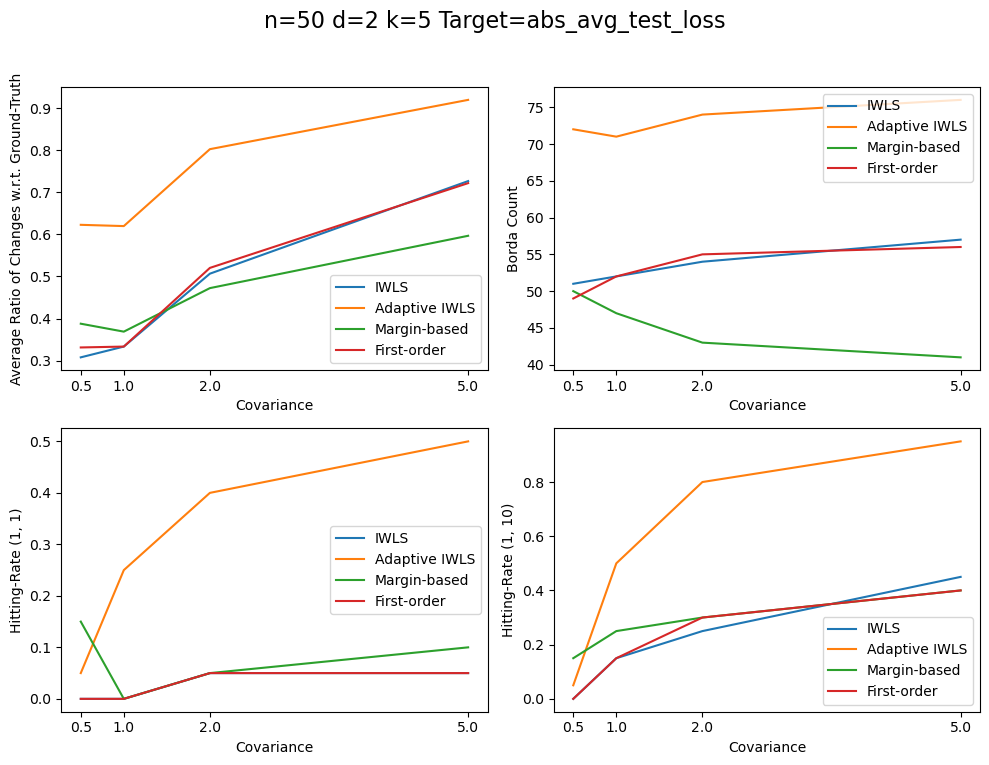

In [15]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle(f'n={n} d={d} k={k} Target={target}', fontsize=16)

# Plot each experiment result in the corresponding subplot
plot_result(axs[0, 0], ratio_result, 'Average Ratio of Changes w.r.t. Ground-Truth')
plot_result(axs[0, 1], Borda_result, 'Borda Count')
plot_result(axs[1, 0], hitting_1_result, 'Hitting-Rate (1, 1)')
plot_result(axs[1, 1], hitting_1_10_result, 'Hitting-Rate (1, 10)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()